# PyTorch: IBA (Per-Sample Bottleneck)

This notebook experiments how the position of the Per-Sample Bottleneck affects the result.


In [1]:
# to set you cuda device
%env CUDA_VISIBLE_DEVICES=0

%load_ext autoreload
%autoreload 2

import torch
import torchvision.models 
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Normalize
import matplotlib.pyplot as plt 
import os
from tqdm import tqdm_notebook
import json
from PIL import Image
import numpy as np
import sys

try:
    import IBA
except ModuleNotFoundError:
    sys.path.insert(0, '..')
    import IBA
    
from IBA.pytorch import IBA, tensor_to_np_img
from IBA.utils import plot_saliency_map

env: CUDA_VISIBLE_DEVICES=0


In [2]:
imagenet_dir = '/home/yang/MLMI_InfoBottleneck/imagenet'

dev = torch.device('cpu:0')

In [3]:
# insert Information Bottleneck after conv 1-1, conv 2-1, conv 3-1, conv 4-1, conv 5-1, conv 5-3
# that are features  0 5 10 17 24 28
# if type(model) == torchvision.models.vgg.VGG:
#     iba = IBA(model.features[17])
# elif type(model) == torchvision.models.resnet.ResNet:
#     iba = IBA(model.layer2)
# elif type(model) == torchvision.models.inception.Inception3:
#     iba = IBA(model.Mixed_5b)

# Define function to perform experiment

The test function takes model and information bottleneck as parameter. Then plot the heapmap at each position respectly.

In [4]:
from copy import deepcopy

def test_iba_position(model, positions):
    # load the data
    if type(model) == torchvision.models.inception.Inception3:
        image_size = 299
    else:
        image_size = 224

    trainset = ImageFolder(
        os.path.join(imagenet_dir, 'train'),
        transform=Compose([
            CenterCrop(256), Resize(image_size), ToTensor(), 
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]))

    with open('imagenet_class_index.json') as f:
        idx2class = {int(k): v[1] for k, v in json.load(f).items()}

    trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)
    
    # load image
    fig, axes = plt.subplots(2, 3, figsize=(20,15))
    
    img = np.array(Image.open("./monkeys.jpg"))
    img = (img.transpose(2, 0, 1) / 255)
    target = 382  # 382: squirrel monkey

    # preprocess image
    img  = Compose([
        Resize(image_size), ToTensor(),  
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])(Image.open("./monkeys.jpg"))
        
    for position, ax in zip(positions, axes.flatten()):
        if type(model) == torchvision.models.vgg.VGG:
            iba = IBA(model.features[position])
        else:
            iba = IBA(getattr(model, position))
        iba.reset_estimate()
        iba.estimate(model, trainloader, device=dev, n_samples=10, progbar=False)

        model_loss_closure = lambda x: -torch.log_softmax(model(x), 1)[:, target].mean()
        heatmap = iba.analyze(img[None].to(dev), model_loss_closure) 
        ax = plot_saliency_map(heatmap, tensor_to_np_img(img), ax=ax)
        if type(model) == torchvision.models.vgg.VGG:
            ax.set_title("Position: feature[{}]".format(position))
        else:
            ax.set_title("Position: {}".format(position))

    fig.suptitle("model: {}, class:{}".format(type(model).__name__, idx2class[target]))
    plt.show()

# Display heatmap for VGG at different position

In [16]:
# insert Information Bottleneck after conv 1-1, conv 2-1, conv 3-1, conv 4-1, conv 5-1, conv 5-3
# that are features  0 5 10 17 24 28
model = torchvision.models.vgg16(pretrained=True)
model.to(dev).eval()
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

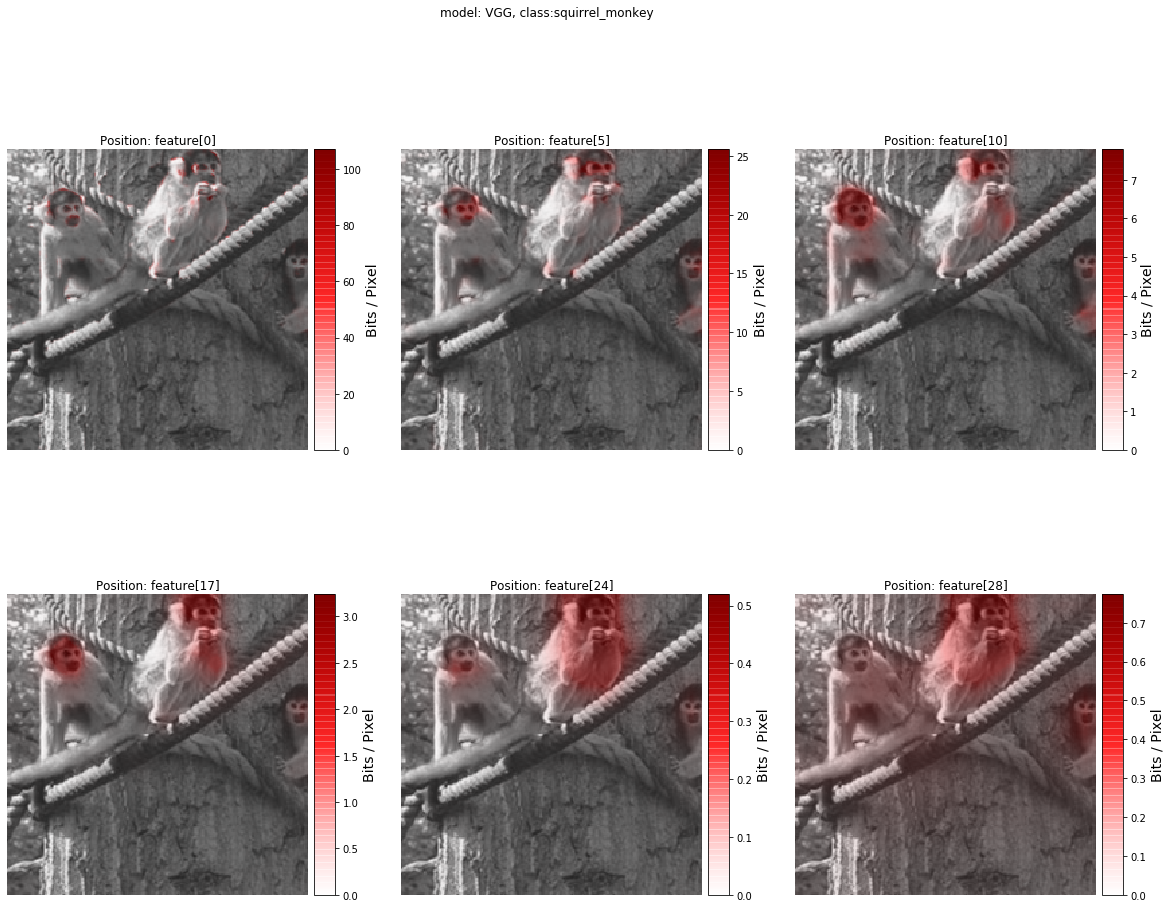

In [17]:
positions = [0, 5, 10, 17, 24, 28]
test_iba_position(model, positions)

# Display heatmap for ResNet at different position

In [22]:
model = torchvision.models.resnet50(pretrained=True)
model.to(dev).eval()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

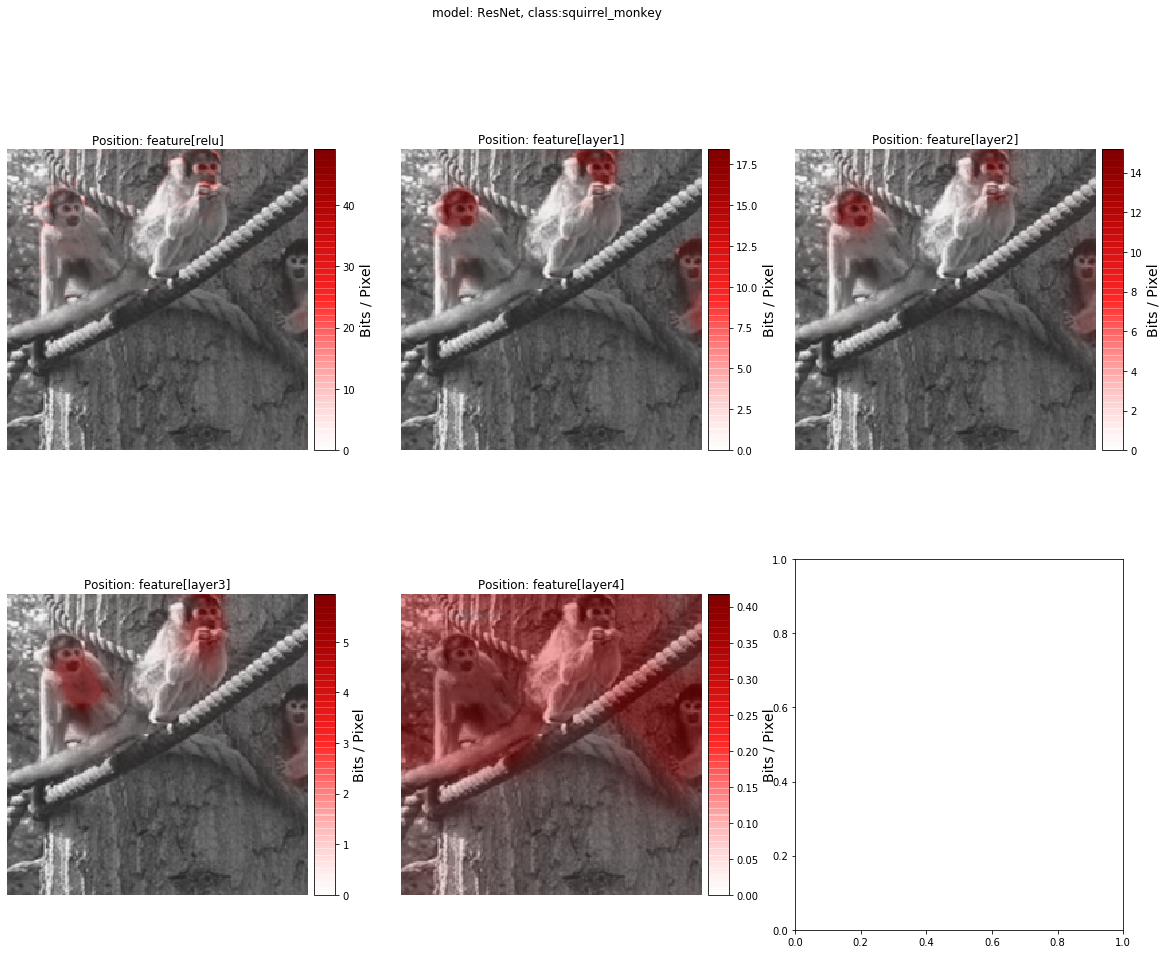

In [25]:
positions = ["relu", "layer1", "layer2", "layer3", "layer4"]
test_iba_position(model, positions)

# Display heatmap for Inception at different position

In [5]:
model = torchvision.models.inception_v3(pretrained=True)
model.to(dev).eval()
print(model)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

/home/yang/MLMI_InfoBottleneck/IBA/IBA/pytorch.py:572: UserWarning: Selected estimator was only fitted on 64 samples. Might not be enough! We recommend 10.000 samples.
  warnings.warn(f"Selected estimator was only fitted on {self.estimator.n_samples()} "


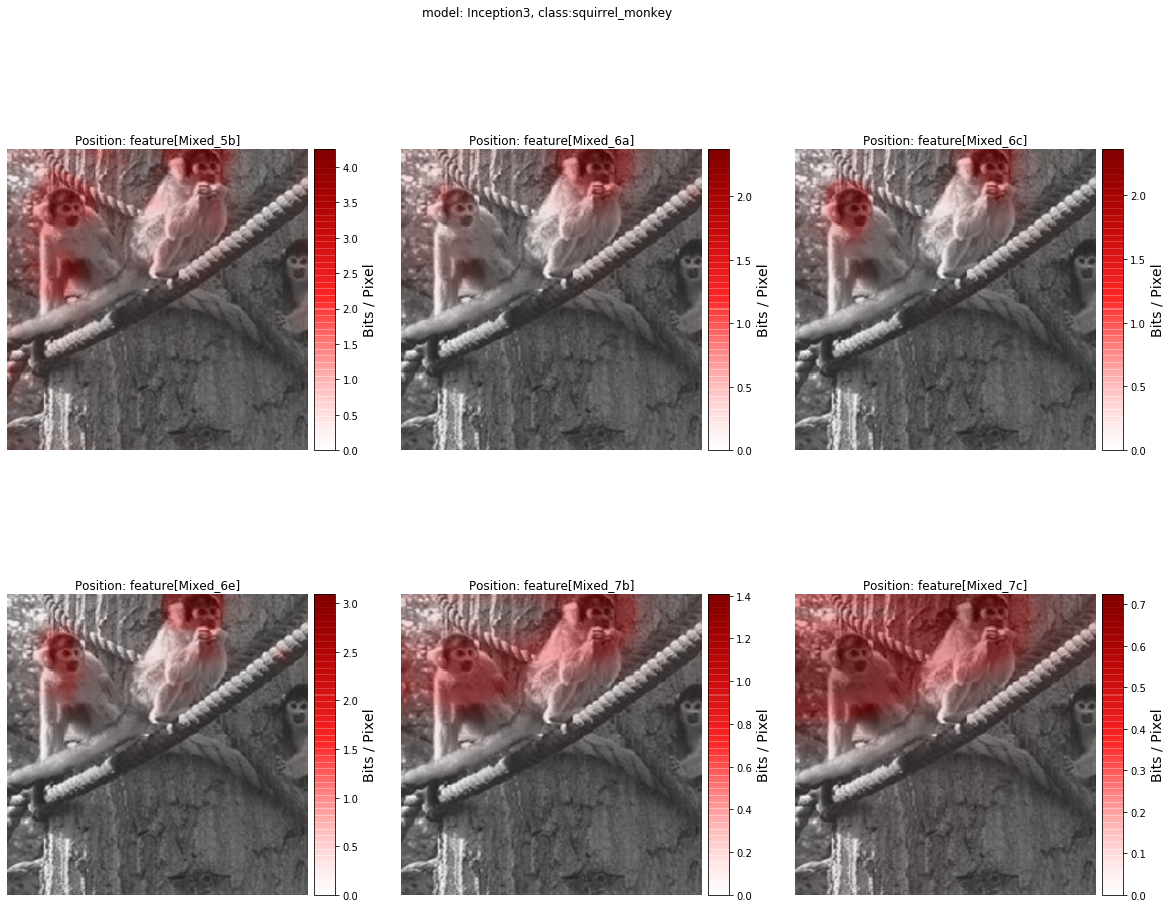

In [6]:
positions = ["Mixed_5b", "Mixed_6a", "Mixed_6c", "Mixed_6e", "Mixed_7b", "Mixed_7c"]
test_iba_position(model, positions)